In [ ]:
#default_exp transform

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from surfbreak import detection
import pipelines
import dask
import graphchain

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('./tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)

with dask.config.set(num_workers=4):
    mean_flow, xrange, yrange = graphchain.get(flow_fit_graph, 'result', scheduler=dask.threaded.get)

print(mean_flow.shape)
print(xrange, yrange)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decodin

In [ ]:
pipelines.describe_graph(flow_fit_graph)

{'flow_tensor_0': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 0, 1)",
 'flow_tensor_1': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 120, 1)",
 'flow_tensor_2': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 240, 1)",
 'flow_tensor_3': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 360, 1)",
 'flow_tensor_4': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 480, 1)",
 'flow_tensor_5': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 600, 1)",
 'flow_tensor_6': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 720, 1)",
 'flow_tensor_7': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 840, 1)",
 'flow_tensor_8': "surfbreak.detection.avg_wave_flows('./tmp/shirahama_1590387334_SURF-93cm.ts', 960, 1)",
 'flow_tensor_9': "surfbreak.detection.

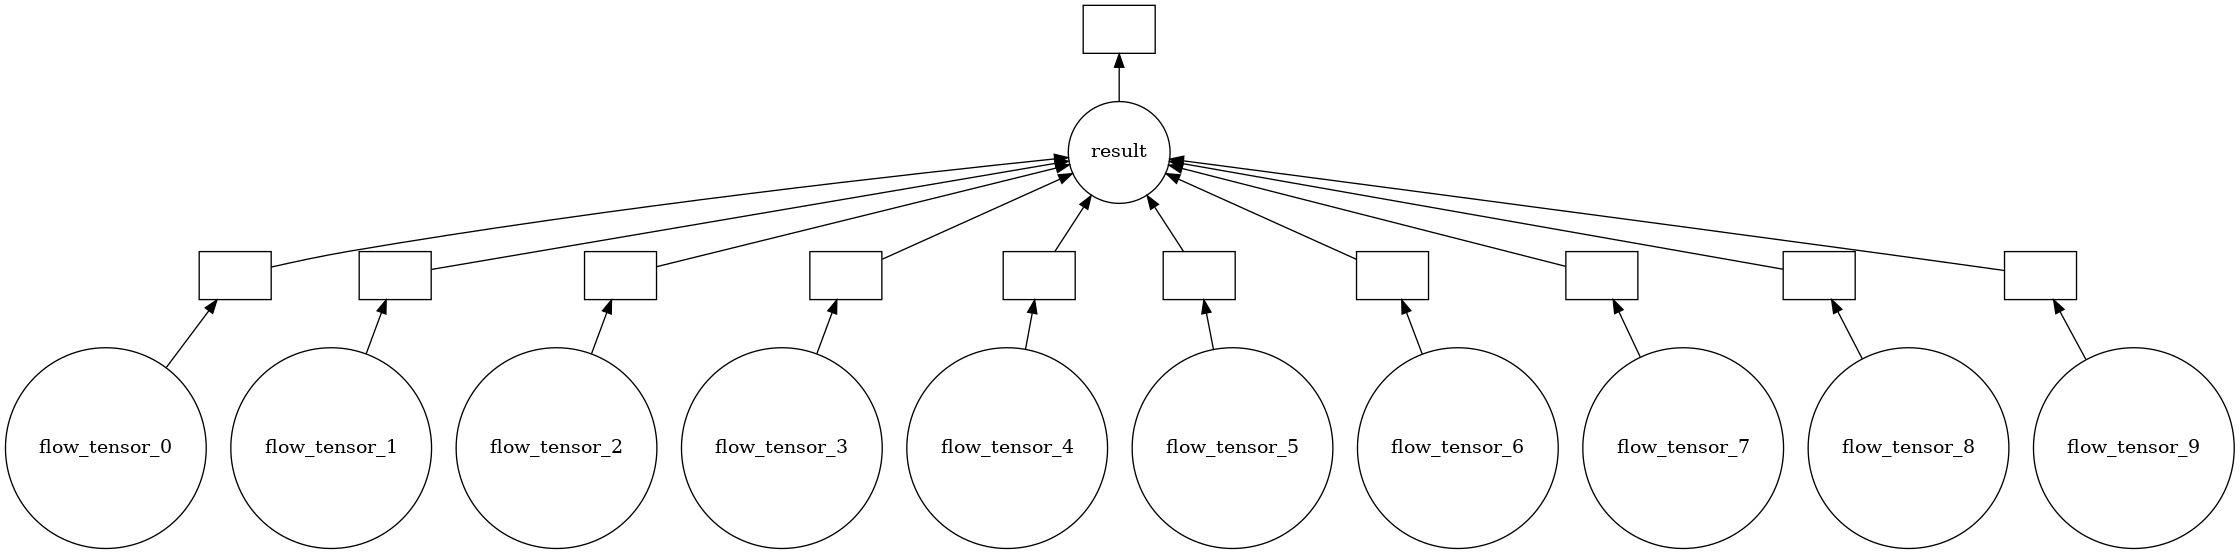

In [ ]:
dask.visualize(flow_fit_graph)

### Extract a grid of wave vectors across the impact zone 

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def vector_tile(mean_flow, xrange, yrange, tilesize = None):
    # Tilesize = pixels along an edge of the vector grid

    surfzone_flow = mean_flow[yrange[0]:yrange[1], xrange[0]:xrange[1]]

    if tilesize is None:
        if surfzone_flow.shape[0] < surfzone_flow.shape[1]//3:
            tilesize = surfzone_flow.shape[0]
        else:
            tilesize = surfzone_flow.shape[1]//3
    
    n_tiles_xdir = surfzone_flow.shape[1]//tilesize
    n_tiles_ydir = surfzone_flow.shape[0]//tilesize

    raw_vector_grid = np.zeros((n_tiles_ydir, n_tiles_xdir, 2))
    vector_grid = np.zeros((n_tiles_ydir, n_tiles_xdir, 3))

    plt.figure(figsize=(15,5))
    for xi in range(n_tiles_xdir):
        for yi in range(n_tiles_ydir):
            vector_grid[yi, xi, :2] = surfzone_flow[tilesize*yi:tilesize*(yi+1),
                                                    tilesize*xi:tilesize*(xi+1)].mean(axis=0).mean(axis=0)
            # Magnitude of the mean vector
            vector_grid[yi, xi, 2]  = np.sqrt(vector_grid[yi, xi, 0]*vector_grid[yi, xi, 0] + 
                                              vector_grid[yi, xi, 1]*vector_grid[yi, xi, 1])
            # Direction of the normalized mean of the x and y vector components
            vector_grid[yi, xi, :2] = normalized(vector_grid[yi, xi, :2])

    max_magnitude = vector_grid[:,:,2].max() 
    for xi in range(n_tiles_xdir):
        for yi in range(n_tiles_ydir):
            vector_grid[yi, xi, 2] = vector_grid[yi, xi, 2] / max_magnitude 
            plt.arrow(xi, yi, 0.6*vector_grid[yi, xi, 0], 0.6*vector_grid[yi, xi, 1],
                      color='k', width=.07, alpha=vector_grid[yi, xi, 2])


    plt.imshow(vector_grid[:,:,2])
    plt.show()
    
    return vector_grid

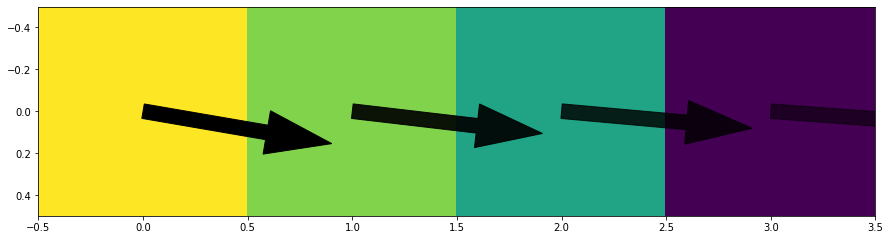

array([[[0.98554863, 0.16939273, 1.        ],
        [0.99320456, 0.11638172, 0.91745621],
        [0.99600472, 0.08930061, 0.81755007],
        [0.99728615, 0.07362288, 0.56199796]]])

In [ ]:
vector_grid = vector_tile(mean_flow, xrange, yrange)
vector_grid

In [ ]:
def shift_img(img, xshift, yshift):
    M = np.array([[1.,0.,xshift],[0.,1.,yshift]], dtype='float32')
    out_img = cv2.warpAffine(img, M, dsize=img.T.shape, borderMode=cv2.BORDER_TRANSPARENT)
    return out_img

## Package into a single function to crop and produce an averaged wave vector

In [ ]:
#export
def trim_image(image, xrange, yrange):
    return image[yrange[0]:yrange[1], xrange[0]:xrange[1]]

In [ ]:
from surfbreak import load_videos
import cv2

video_file = './tmp/shirahama_1590387334_SURF-93cm.ts'

frames = load_videos.decode_frame_sequence(video_file, duration_s=1, start_s=50, RGB=True,
                                              one_image_per_n_frames=2)

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 


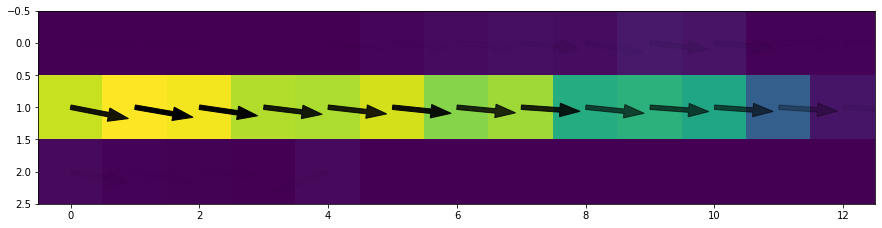

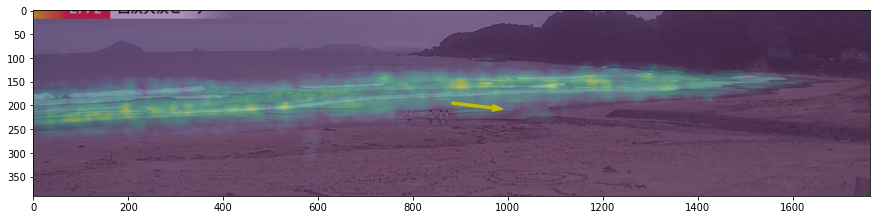

In [ ]:
wave_img = detection.trim_image(frames[0], xrange, yrange)


tilesize = wave_img.shape[0]//3

vector_grid = vector_tile(mean_flow, xrange, yrange, tilesize=tilesize)


avg_wave_xdir = detection.trim_image(mean_flow[:,:,0], xrange, yrange).mean()
avg_wave_ydir = detection.trim_image(mean_flow[:,:,1], xrange, yrange).mean()
wave_vector = (avg_wave_xdir*2000, avg_wave_ydir*2000)

mean_flow_mag = np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])

trimmed_mag = detection.trim_image(mean_flow_mag, xrange, yrange)
center = ((xrange[1] - xrange[0])//2, (yrange[1] - yrange[0])//2)

plt.figure(figsize=(15,5))
plt.imshow(wave_img)
plt.arrow(center[0], center[1], wave_vector[0], wave_vector[1], color='y', width=5)
plt.gca().imshow(trimmed_mag, alpha=0.4)

In [ ]:
#export
def fit_line(heatmap, plot=False):
    
    high_indicies = np.where(heatmap > heatmap.mean())
    
    high_idx_array = np.dstack(high_indicies)[0][:,::-1]
    
    # https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=fitline#fitline
    line_def = cv2.fitLine(high_idx_array, 1, 0, 1, 0.1)
    # Y is down, X is to right in image space
    vx, vy, x0, y0 = line_def 

    line_half_length = heatmap.shape[1]/3
    x1 = x0 - vx*line_half_length 
    y1 = y0 - vy*line_half_length
    x2 = x0 + vx*line_half_length
    y2 = y0 + vy*line_half_length
    end_points = ((x1,y1), (x2,y2))

    if plot:    
        img = cv2.line(heatmap.copy(), (x1, y1), (x2, y2), .5, thickness=8)
        plt.imshow(img, )
    
    return line_def, end_points


In [ ]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


array([[ 9.9907291e-01],
       [-4.3049708e-02],
       [ 7.6386218e+02],
       [ 1.7911110e+02]], dtype=float32)

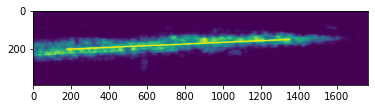

In [ ]:
import numpy as np
line, end_points = fit_line(trimmed_mag, plot=True)
line

## Calculate a homogrophy transform
https://docs.opencv.org/master/d9/dab/tutorial_homography.html

In [ ]:
def flow_mag_at_point(flow_mag, point, windowsize=100, percentile=90):
    xrange = (int(point[0] - windowsize/2), int(point[0] + windowsize/2))
    yrange = (int(point[1] - windowsize/2), int(point[1] + windowsize/2))
    window_mag = trim_image(flow_mag, xrange, yrange)
    # Find the 90th percentile value of the magnitudes which are greater than the mean
    # (Goal is to find the highest "reasonable" value)
    flow_magnitude = np.percentile(window_mag[window_mag > window_mag.mean()],percentile)
    return flow_magnitude

In [ ]:
for pct in [60,80,90,95]:
    leftmag = flow_mag_at_point(trimmed_mag, end_points[0], percentile=pct)
    rightmag = flow_mag_at_point(trimmed_mag, end_points[1], percentile=pct)
    print(pct, '\t',leftmag, '\t' ,rightmag)

60 	 0.3388531982898712 	 0.2984108030796051
80 	 0.38411021828651426 	 0.3285099685192108
90 	 0.4104335576295852 	 0.35139080286026003
95 	 0.42856852859258643 	 0.36796653866767876


array([[ 178.1742 ,  245.42963],
       [ 174.64038,  163.41904],
       [1352.8298 ,  188.90437],
       [1349.8044 ,  118.69136]], dtype=float32)

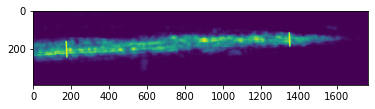

In [ ]:
leftmag = flow_mag_at_point(trimmed_mag, end_points[0], percentile=90)
rightmag = flow_mag_at_point(trimmed_mag, end_points[1], percentile=90)

dx = line[0]; dy = line[1]

# Note. here dy is being used for X coordinates and vice/versa because perpendeicular = swapped dx/dy ratio 
left_top_pt     = (end_points[0][0] - 100*dy*leftmag,  end_points[0][1] + 100*dx*leftmag)
left_bottom_pt  = (end_points[0][0] + 100*dy*leftmag,  end_points[0][1] - 100*dx*leftmag)
right_top_pt    = (end_points[1][0] - 100*dy*rightmag, end_points[1][1] + 100*dx*rightmag)
right_bottom_pt = (end_points[1][0] + 100*dy*rightmag, end_points[1][1] - 100*dx*rightmag)

img = cv2.line(trimmed_mag.copy(), left_top_pt, left_bottom_pt, .5, thickness=8)
img2 = cv2.line(img.copy(), right_top_pt, right_bottom_pt, .5, thickness=8)
plt.imshow(img2)

corners1 = np.stack([np.concatenate(tup) for tup in [left_top_pt, left_bottom_pt, right_top_pt, right_bottom_pt]], axis=0)
corners1

array([[ 176.40729,  245.46768],
       [ 176.40729,  163.38098],
       [1352.4075 ,  245.46768],
       [1352.4075 ,  163.38098]], dtype=float32)

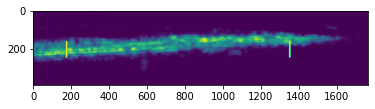

In [ ]:
len_line = np.sqrt((end_points[1][0]-end_points[0][0])**2 + (end_points[1][1]-end_points[0][1])**2)

# Since this is now aligned to X axis, dy is all 0 and dx is 1.  Also, rightmag is set equal to leftmag
post_left_top_pt     = (end_points[0][0],            end_points[0][1] + 100*leftmag)
post_left_bottom_pt  = (end_points[0][0],            end_points[0][1] - 100*leftmag)
post_right_top_pt    = (end_points[0][0] + len_line, end_points[0][1] + 100*leftmag)
post_right_bottom_pt = (end_points[0][0] + len_line, end_points[0][1] - 100*leftmag)

img = cv2.line(trimmed_mag.copy(), post_left_top_pt, post_left_bottom_pt, .5, thickness=8)
img2 = cv2.line(img.copy(), post_right_top_pt, post_right_bottom_pt, .5, thickness=8)
plt.imshow(img2)

corners2 = np.stack([np.concatenate(tup) for tup in 
                     [post_left_top_pt, post_left_bottom_pt, post_right_top_pt, post_right_bottom_pt]], axis=0)
corners2

In [ ]:
H, _ = cv2.findHomography(corners1, corners2)
print(H)

[[ 8.17057432e-01 -3.52069207e-02  3.59287806e+01]
 [ 1.77040364e-02  9.80074826e-01 -3.15305122e+00]
 [-1.19758765e-04  5.15955912e-06  1.00000000e+00]]


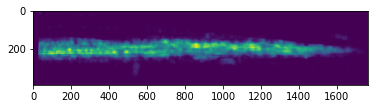

In [ ]:
mag_warped = cv2.warpPerspective(trimmed_mag, H, (trimmed_mag.shape[1], trimmed_mag.shape[0]))
plt.imshow(mag_warped)

### Compare images pre- and post- homography transform

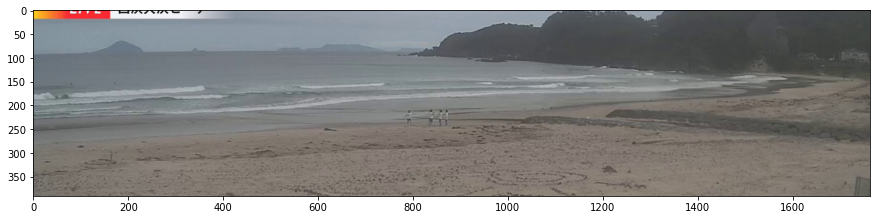

In [ ]:
# Image pre-transform
plt.figure(figsize=(15,5))
plt.imshow(wave_img)

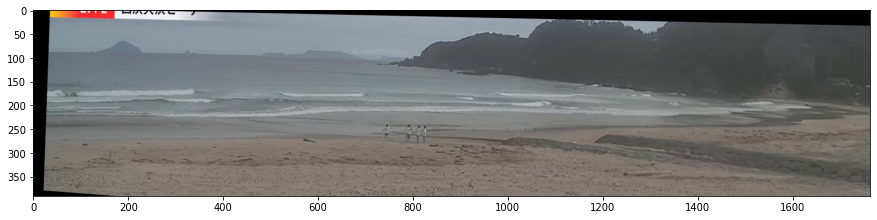

In [ ]:
# Image post-transform
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped)

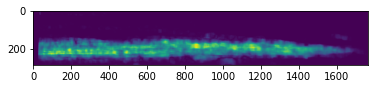

In [ ]:

max_to_crop = mag_warped.sum() / 20
cropped_sum = 0
last_x_idx = mag_warped.shape[0]
for i in range(last_x_idx):
    if cropped_sum > max_to_crop:
        rows_to_crop = i - (last_x_idx//10 + 1)  # margin to back off from bottom of waves
        break
    else:
        cropped_sum += mag_warped[last_x_idx - i - 1].sum()
plt.imshow(mag_warped[:-1 - rows_to_crop])        

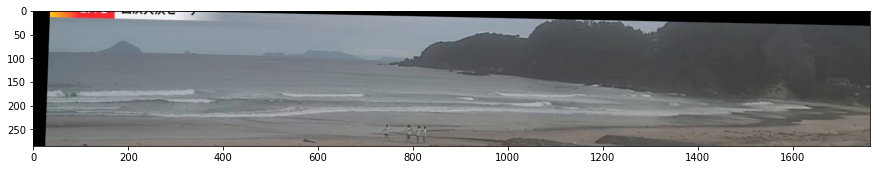

In [ ]:
img_warped = cv2.warpPerspective(wave_img, H, (wave_img.shape[1], wave_img.shape[0]))
plt.figure(figsize=(15,5))
plt.imshow(img_warped[:-1-rows_to_crop])

## Some key camera  assumption we can make: 
1. Camera should have only yaw and pitch vs. horizon (approximately zero roll)
1. Ocean surface is flat (on average, over time)
1. Camera is definitely above wave surface looking down
1. If angle between wave flow vector and surf zone line is strongly acute, surf line is likely receeding from camera.

In [ ]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 02_wave_detection.ipynb.
Converted 03_perspective_transform.ipynb.
Converted index.ipynb.
